In [1]:
import cv2
import string
import numpy as np
import os
from keras import layers #for building layers of neural net
from keras.models import Model
from keras.models import load_model
from keras import callbacks #for training logs, saving to disk periodically
from matplotlib import pyplot as plt

2022-07-10 11:05:05.323195: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-10 11:05:05.323310: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Reconhecedor CAPTCHA

CAPTCHA significa “Completely Automated Public Turing test to tell Computers and Humans Apart” (Teste de Turing Público Completamente Automatizado para diferenciar computadores e humanos) e como o nome sugere é um modo de evitar que computadores façam ações por si mesmos que orignalmente requerem o manuseio por humanos, como um sistema de votos online por exemplo. Porém, utilizando o conceito de deep learning e visão computacional, o CAPTCHA pode ser "derrotado". Tal objetivo pode ser atingido com a ajuda de Convolutional Neural Networks(CNN). Uma CNN é um algoritmo de deep learning que recebe uma imagem como entrada e, em seguida, atribui algum valor a várias *features* da imagem. Seu principal objetivo é transformar as imagens em um formato muito mais fácil de processar, sem perder *features* essenciais para obter uma previsão otimizada.

### Descrição do Dataset

O conjunto de dados usado para este projeto consiste em 10000 imagens .jpg de CAPTCHA baseado em texto. Cada imagem do conjunto de dados tem um conjunto de 6 caracteres e o conjunto de caracteres é definido como todas as letras maiúsculas e dígitos de 0 a 9. Portanto, um total de 36 caracteres está presente no conjunto de caracteres.
O conjunto de dados é separado em treinamento (utilizado para treinar o modelo), com 8000 imagens, validação com 1000 imagens e teste com 1000 imagens. O aprendizado é feito apenas com a utilização das imagens contidas no diretório treinamento e a validação de parâmetros é feita apenas com imagens do diretório validação. As imagens do diretório teste são utilizadas para avaliação do método.

### Etapas

1. Pré processamento dos dados


In [2]:
IMG_WIDTH = 180
IMG_HEIGHT = 50
NUM_TRAINING_IMGS = 8000
NUM_TEST_IMGS = 1000

NUM_CHARS_IN_CAPTCHA = 6

IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 1) # 1 is the number of channels

CHARACTERS = string.ascii_uppercase + "0123456789"
N_CHARS = len(CHARACTERS)
N_CHARS

36

0
R
17
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1
N
13
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2
I
8
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3
N
13
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4
I
8
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
5
C
2
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
RNINIC
(6, 36)


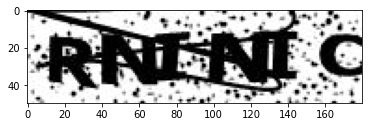

In [3]:
def get_labels():
    labels = []
    sorted = os.listdir("dados/CAPTCHA-10k/labels10k")
    sorted.sort()
    
    for i in sorted:
        captcha = open("dados/CAPTCHA-10k/labels10k/" + i, 'r').read().strip()
        labels.append(captcha)

    return labels

def get_X_and_y(type, labels):
    n = NUM_TRAINING_IMGS
    shift = 0

    if type == "validacao":
        n = NUM_TEST_IMGS
        shift = 8000

    if type == "teste":
        n = NUM_TEST_IMGS
        shift = 9000
    

    X = np.zeros((n, IMG_HEIGHT, IMG_WIDTH, 1))
    y = np.zeros((NUM_CHARS_IN_CAPTCHA, n, N_CHARS))

    files = os.listdir("dados/CAPTCHA-10k/" + type)
    files.sort()

    for i, pic in enumerate(files):
        img = cv2.imread(os.path.join("dados/CAPTCHA-10k/" + type, pic), cv2.IMREAD_GRAYSCALE) #Read image in grayscale
        pic_target = labels[i + shift]

        if len(pic_target) < 7:
            img = img / 255.0 #scales the image between 0 and 1
            img = np.reshape(img, (IMG_HEIGHT, IMG_WIDTH, 1)) 

            target=np.zeros((NUM_CHARS_IN_CAPTCHA, N_CHARS)) #creates an array of size 5*36 with all entries 0

            for j, k in enumerate(pic_target):
                
                #j iterates from 0 to 4(5 letters in captcha)
                #k denotes the letter in captcha which is to be scanned
                index = CHARACTERS.find(k) #index stores the position of letter k of captcha in the character string
                target[j, index] = 1 #replaces 0 with 1 in the target array at the position of the letter in captcha
                
                if (pic_target) == "RNINIC":
                    print(j)
                    print(k)
                    print(index)
                    print(target[j])

            X[i] = img
            y[:,i] = target

    return X, y

labels = get_labels()
X, y = get_X_and_y(type="treinamento", labels=labels)

plt.imshow(X[0], cmap=plt.get_cmap("gray"))
print(labels[0])
print(y[:,0].shape)

## Create Model

In [9]:
def createModel():
    img = layers.Input(shape=IMG_SHAPE) # Get image as an input of size 50,200,1
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img) #50*200
    
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 25*100
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 13*50
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    
    mp3 = layers.MaxPooling2D(padding='same')(conv3)  # 13*50
    conv4 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp3)

    bn = layers.BatchNormalization()(conv4) #to improve the stability of model
    mp4 = layers.MaxPooling2D(padding='same')(bn)  # 7*25
    
    flat = layers.Flatten()(mp4) #convert the layer into 1-D

    outs = []
    for _ in range(6): #for 6 letters of captcha
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1) #drops 0.5 fraction of nodes
        res = layers.Dense(N_CHARS, activation='sigmoid')(drop)

        outs.append(res) #result of layers
    
    # Compile model and return it
    model = Model(img, outs) #create model
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
    return model

In [10]:
model = createModel()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 50, 180, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_9 (Conv2D)              (None, 50, 180, 16)  160         ['input_4[0][0]']                
                                                                                                  
 max_pooling2d_9 (MaxPooling2D)  (None, 25, 90, 16)  0           ['conv2d_9[0][0]']               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 25, 90, 32)   4640        ['max_pooling2d_9[0][0]']  

In [11]:
hist = model.fit(X, [y[0], y[1], y[2], y[3], y[4], y[5]], batch_size=32, epochs=25, validation_split=0.2)

Epoch 1/25
200/200 [==============================] - 21s 95ms/step - loss: 21.5739 - dense_37_loss: 3.5960 - dense_39_loss: 3.5917 - dense_41_loss: 3.6008 - dense_43_loss: 3.5939 - dense_45_loss: 3.5948 - dense_47_loss: 3.5967 - dense_37_accuracy: 0.0314 - dense_39_accuracy: 0.0325 - dense_41_accuracy: 0.0258 - dense_43_accuracy: 0.0303 - dense_45_accuracy: 0.0388 - dense_47_accuracy: 0.0298 - val_loss: 21.4727 - val_dense_37_loss: 3.5791 - val_dense_39_loss: 3.5791 - val_dense_41_loss: 3.5790 - val_dense_43_loss: 3.5791 - val_dense_45_loss: 3.5770 - val_dense_47_loss: 3.5794 - val_dense_37_accuracy: 0.0275 - val_dense_39_accuracy: 0.0325 - val_dense_41_accuracy: 0.0319 - val_dense_43_accuracy: 0.0237 - val_dense_45_accuracy: 0.0338 - val_dense_47_accuracy: 0.0262
Epoch 2/25
200/200 [==============================] - 19s 94ms/step - loss: 21.4533 - dense_37_loss: 3.5760 - dense_39_loss: 3.5783 - dense_41_loss: 3.5776 - dense_43_loss: 3.5780 - dense_45_loss: 3.5638 - dense_47_loss: 3.5